# Target variable creation && Regression modelling

## Libraries

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Feature selection
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as stats

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scores
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# Settings & warning handling
import warnings
pd.options.display.max_columns
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

### Loading Data

### Data
 
| Attributes | Representation|
| -------- | ---------- |
| CreditScore| Standardized credit score for loan origination|
| FirstPaymentDate| Due date for first scheduled loan payment. | 
| FirstTimeHomebuyer| Indicator for first-time homebuyer qualification|
| MaturityDate | The month and year that the final scheduled payment on the loan is due|
| MSA | Mortgage Security Amount the determined by the appraiser|
| MIP | percentage of loan paid monthly depends on down payment|
| Units | Number of units in the mortgaged property at the time the loan was originated|
| Occupancy | property occupancy status|
| OCLTV | Ratio calculated by dividing outstanding loans by property value|
| DTI | Ratio of total monthly debt by total monthly income to evaluate an applicant's ability to repay the loan|
| OrigUPB |  The unpaid principal balance of the loan as it contributes to the current balance of the security|
| LTV | amount the lender will pay|
| OrigInterestRate| The interest rate of the loan as stated on the note the time the loan was originated|
| Channel |  how the loan was delivered to the issuer|
| PPM | Prepayment Penalty denotes whether the borrower is subject to a penalty for early payment of principal|
| ProductType | classification of the loan as having either a fixed- or an adjustable-interest rate|
| PropertyState | denotes the location of the property securing the loan|
| PropertyType | type of property that secures the loan|
| PostalCode | specific numbers, and sometimes letters, that help postal services deliver mail |
| LoanSeqNum | The unique designation assigned to the loan by the issuer|
| LoanPurpose | how loan amount can be used ~ Cash-out: no limitations on loan purpose ,No Cash-out: limited usage|
| OrigLoanTerm | Original loan term: months for scheduled borrower payments at origination|
| NumBorrowers | The number of borrowers who, at the time the loan was originated, are obligated to repay the loan|
| SellerName | name of the entity that sold the loan to the issuer|
| ServicerName | name of the entity that services the loan during the current reporting period|
| EverDelinquent | borrower's history of being delinquent on their loan payments at any point|
| MonthsDelinquent | number of months that a borrower has failed to make their scheduled loan payments on time|
| MonthsInRepayment | number of months that a borrower has been making regular payments on a loan|

In [2]:
df = pd.read_csv("LoanExport.csv")

# Creating target Variable

### Equated Monthly Installment - EMI

EMI for short - is the amount payable every month to the bank or any other financial institution until the loan amount is fully paid off. It consists of the interest on loan as well as part of the principal amount to be repaid.



**Here the EMI formula:** 
<center>
  <img src="https://github-production-user-asset-6210df.s3.amazonaws.com/89405673/263004315-582c9aab-6129-4372-8939-edc73b75119b.jpeg" width="300" height="120"/>
</center>


**NOTE:** This following formula seems more simplier than the original
<center>
  <img src="https://github-production-user-asset-6210df.s3.amazonaws.com/89405673/263217837-4e98265a-0c65-4536-94b7-73c349da5f21.png" width="400" height="130">
</center>

Where,
P: Principal loan amount (= OrigUPB)

n: Loan tenure in months (= OrigLoanTerm)

r: Interest rate per month (= OrigInterestRate)

DEBT: EMI (so income = EMI / DTI)

In [3]:
# n are really big for X**(n) operation so it is better to go with X**(-n)
def calculate_EMI(P, r, n):
    return P * r * (1 / (1 - (1 + r) ** (-n)))

df['EMI'] = np.vectorize(calculate_EMI)(df["OrigUPB"], df["OrigInterestRate"] , df["OrigLoanTerm"])

# first 5 rows of EMI column
print(df["EMI"].head())

0     789750.0
1     708500.0
2     605000.0
3    1100000.0
4     776625.0
Name: EMI, dtype: float64


### Total Payment and Interest Amount
We can calculate total payment by multiplying the EMI with the loan tenure and interest amount by simply subtracting total payment and principal amount.


In [13]:
df["totalPayment"]    = df["EMI"] * df["OrigLoanTerm"]
df["monthlyInterest"] = df["interestAmount"] / df["OrigLoanTerm"]
df["interestAmount"]  = df["totalPayment"] - df["OrigUPB"]


features_list = ["EMI", "OrigLoanTerm", "OrigUPB", "interestAmount", "monthlyInterest"]

print(df[features_list].head())

         EMI  OrigLoanTerm  OrigUPB  interestAmount  monthlyInterest
0   789750.0           360   117000     284193000.0     7.894250e+05
1   708500.0           360   109000     254951000.0     7.081972e+05
2   605000.0           360    88000     217712000.0     6.047556e+05
3  1100000.0           360   160000     395840000.0     1.099556e+06
4   776625.0           360   109000     279476000.0     7.763222e+05


### Current principal
The principal amount remaining depends on the months in repayment, the more months you have paid the less will be the left over principal. We can find out the current principal for each person with the help of monthly interest rate, actual principal, EMI they pay per month and months in repayment.

In [14]:
def principal(r, amount, emi, month):
    for i in range(month):
        interest = r * amount
        p = emi - interest
        amount -= p
    return amount

df["currentPrincipal"] = np.vectorize(principal)(df["OrigInterestRate"], df["OrigUPB"], df["EMI"], df["MonthsInRepayment"])

print(df["currentPrincipal"].head())

0    117000.0
1    109000.0
2     88000.0
3    160000.0
4    109000.0
Name: currentPrincipal, dtype: float64


# Monthly Income
We are give DTI which is the ratio of debt to income, and because we know the monthly debt i.e. the monthly EMI we can calculate the monthly income by swapping it with DTI .

In [15]:
def compute_monthly_income(dti, emi):
    if dti == 0:
        return 0.01
    return  emi / dti

df["monthlyIncome"] = np.vectorize(compute_monthly_income)(df["DTI"], df["EMI"])

print(df["monthlyIncome"].head())

0    29250.000000
1    41676.470588
2    37812.500000
3    78571.428571
4    43145.833333
Name: monthlyIncome, dtype: float64


### prePayment

For having a simple model, we are assuming that a person is going to save up money based on their DTI for 2 years and pre-pay the residual amount after subtracting it with the EMI of those 2 years. We have also assumed that a person with DTI less than 40 is going to save up 50% of his income while a person with DTI more than 40% is going to save up 75% of his income and these savings are inclusive of EMI, so for example if a person has DTI of 25% and he is going to pre-pay 50-25=25% of his income.

In [22]:
def compute_pre_payment(dti, income):
    if dti < 40:
        return income/2
    else:
        return income * (3/4)

df["prePayment"] = np.vectorize(compute_pre_payment)(df["DTI"], df["monthlyIncome"] * 24)

M = max(df["prePayment"])
m = min(df["prePayment"])
print(f"max : {M}")
print(f"min : {m}")

max : 22680000.0
min : 0.12


In [23]:
df["SPP"] = (df["EMI"]-df["monthlyInterest"]) * df["OrigLoanTerm"]
df["APP"] = (df["EMI"]-df["monthlyInterest"]) * df["MonthsInRepayment"] + df["prePayment"]
df["OPB"] = df["currentPrincipal"]
df["PPR"] = abs(df["SPP"] - df["APP"]) / df["OPB"]

features = ["SPP", "APP", "OPB", "PRR"]

M = max(df["PPR"])
m = min(df["PPR"])

print(f"max : {M}")
print(f"min : {m}")

max : 98.37500000000003
min : 0.4094694334077507


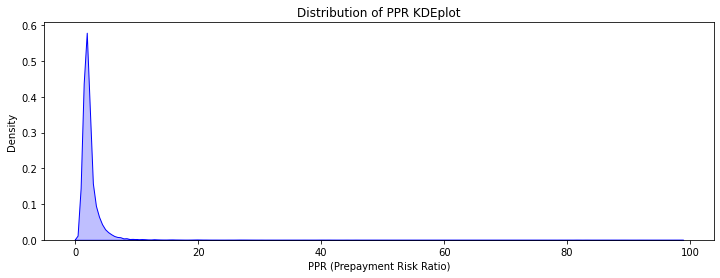

In [24]:
plt.figure(figsize=(12, 4))

# Kernel Density Plot - KDE
sns.kdeplot(data=df['PPR'], color='blue', fill=True)
plt.xlabel('PPR (Prepayment Risk Ratio)')
plt.ylabel('Density')
plt.title('Distribution of PPR KDEplot')
plt.show()

In [27]:
# categorical variables
target = 'PPR'
cat_cols = df.select_dtypes("object").columns

# numerical variables
num_cols = df.select_dtypes(exclude="object").columns

In [28]:
# let's check number of values in each categorical column
df[cat_cols].nunique()

FirstTimeHomebuyer         3
MSA                      392
Occupancy                  3
Channel                    4
PPM                        3
ProductType                1
PropertyState             53
PropertyType               7
PostalCode              1767
LoanSeqNum            291451
LoanPurpose                3
NumBorrowers               3
SellerName                20
ServicerName              20
dtype: int64

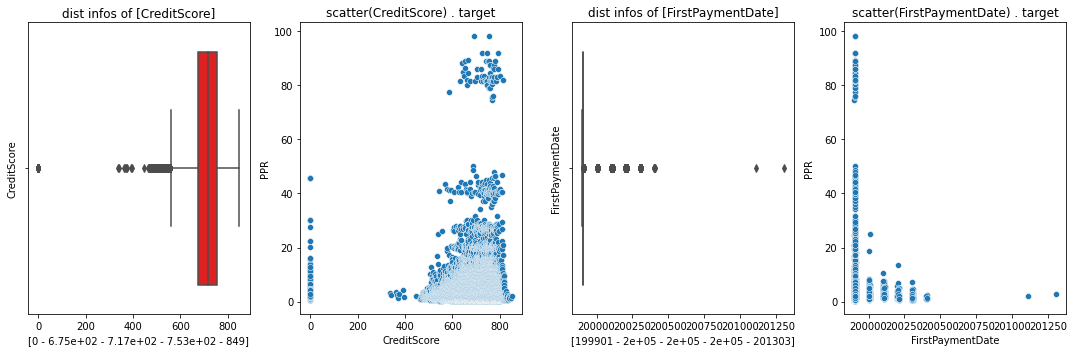

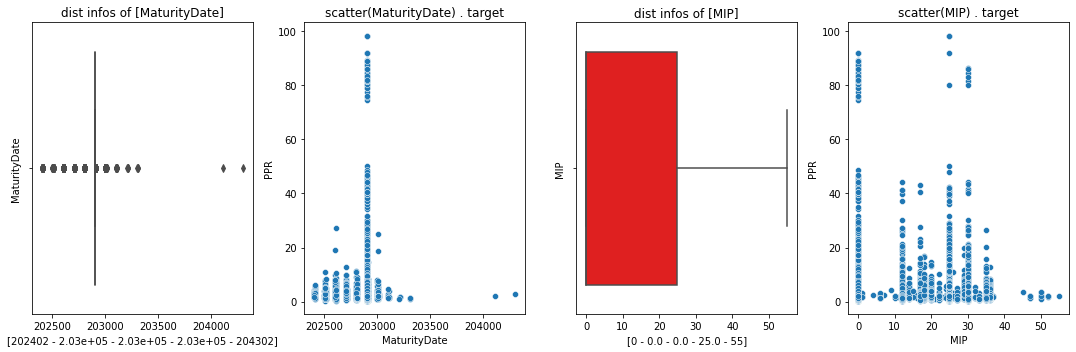

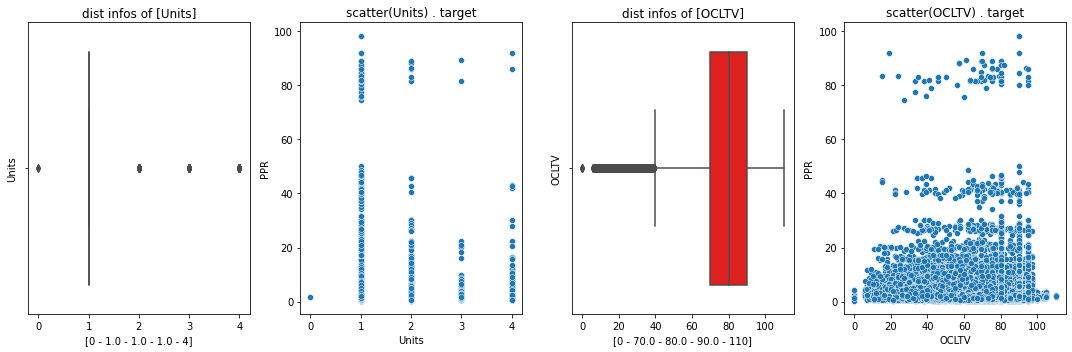

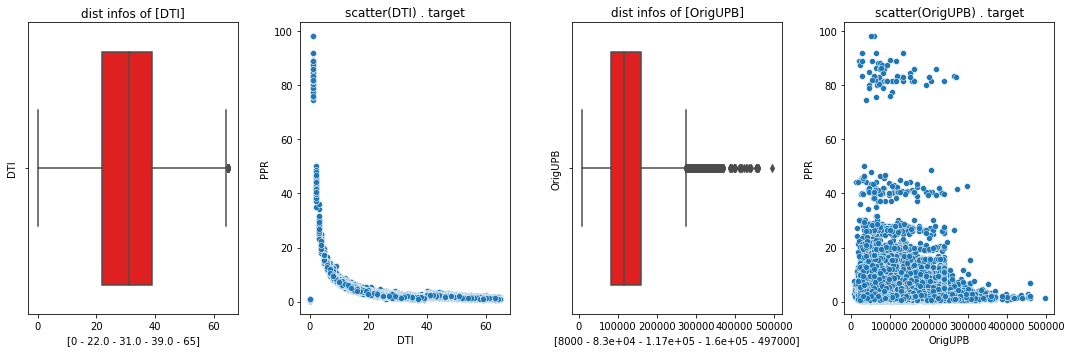

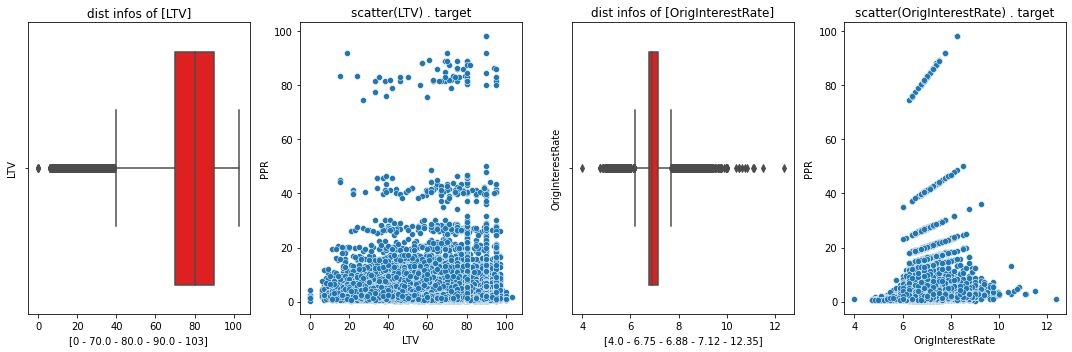

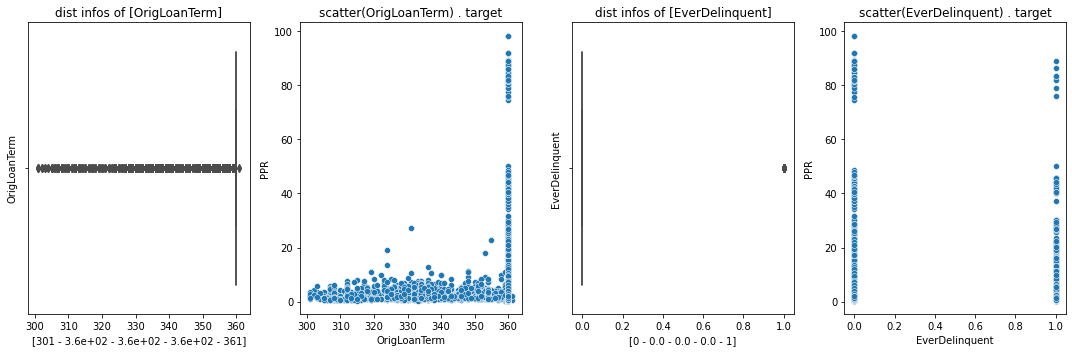

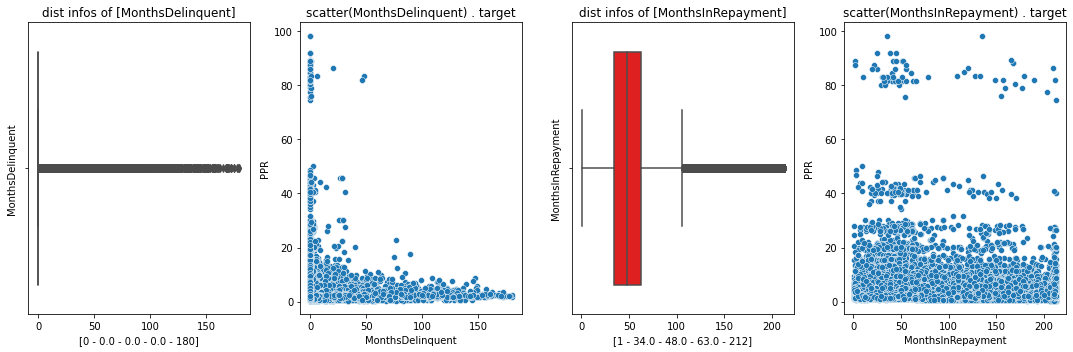

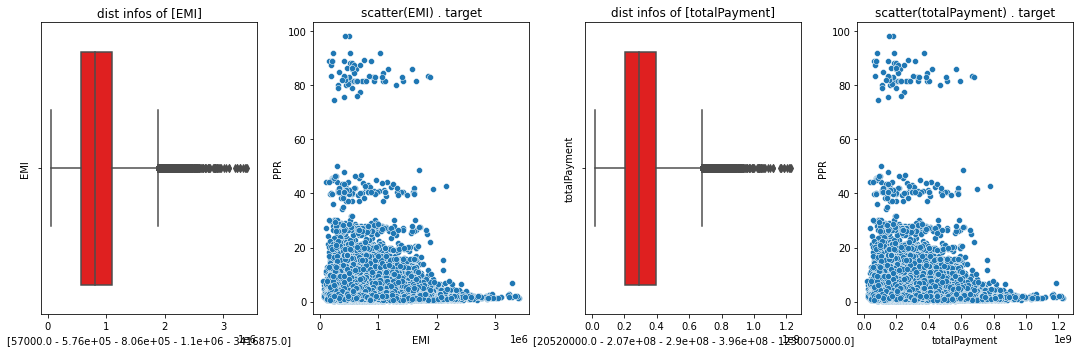

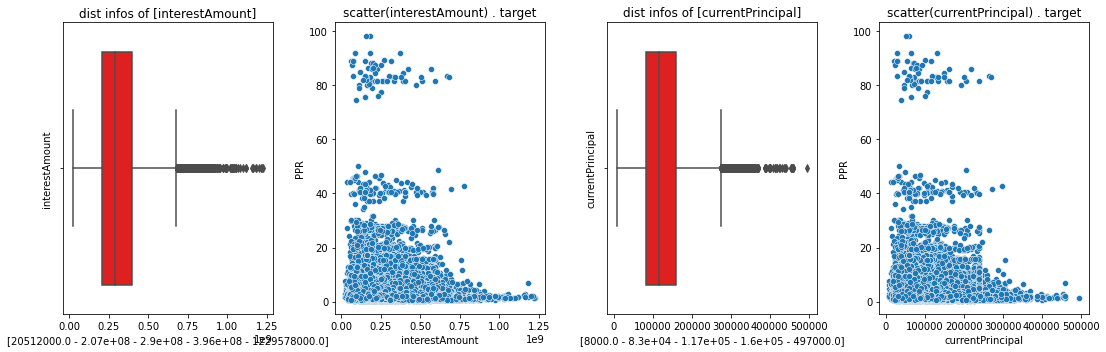

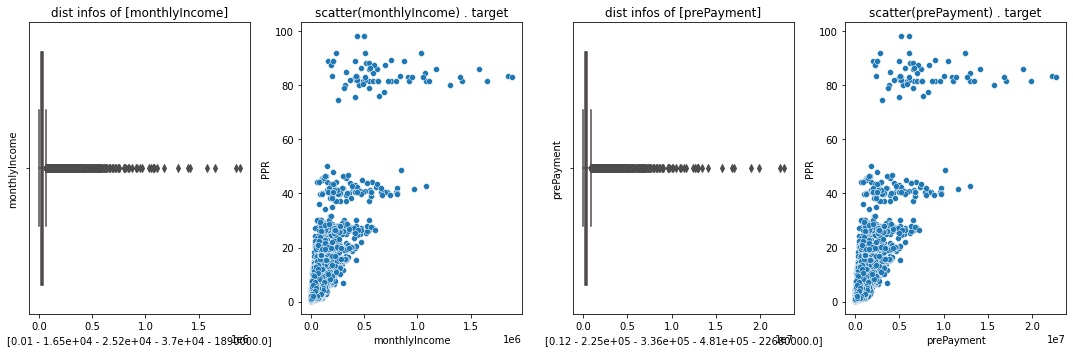

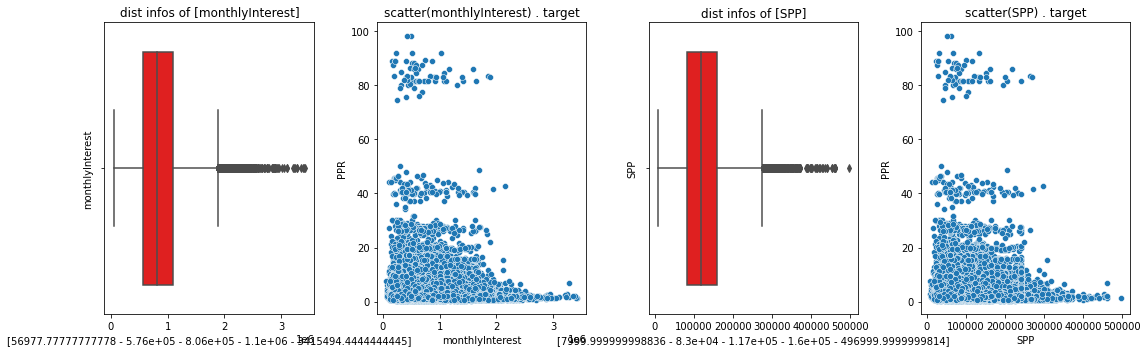

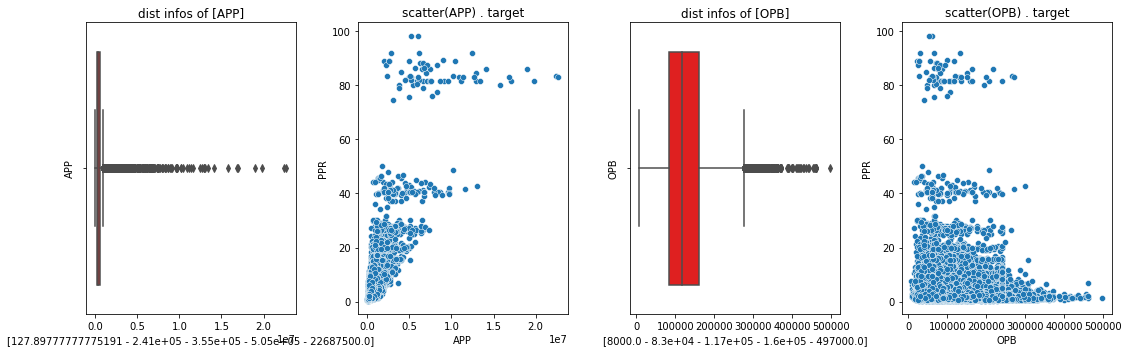

Index(['CreditScore', 'FirstPaymentDate', 'MaturityDate', 'MIP', 'Units',
       'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'OrigLoanTerm',
       'EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment', 'EMI',
       'totalPayment', 'interestAmount', 'currentPrincipal', 'monthlyIncome',
       'prePayment', 'monthlyInterest', 'SPP', 'APP', 'OPB'],
      dtype='object')

In [29]:
# # dropping the target column
if target in num_cols:
    num_cols = num_cols.drop(target)

# # Create the scaler
scaler = StandardScaler()

# # normalazing the num cols
normalized_data = pd.DataFrame(data=scaler.fit_transform(df[num_cols]),
                               columns=df[num_cols].columns)

g_per_row = 2
for i in range(0, len(num_cols), g_per_row):
  num_graph = len(num_cols) - i if len(num_cols)-i < g_per_row else g_per_row
  fig, axes = plt.subplots(1, 2*g_per_row, figsize=(15, 5))
  for j,k in enumerate(range(0,2*num_graph-1,2)):
    col = num_cols[i+j]

    # building the boxplot (will gives us the boundaries of the meaningfull data)
    sns.boxplot(x=df[col], color='red', ax=axes[k])
    axes[k].set_title(f'dist infos of [{col}]')
    axes[k].set_ylabel(col)


    quantile = df[col].quantile([0.25,0.5,0.75])
    Q1 = quantile[0.25]
    Q3 = quantile[0.75]
    median = df[col].median()
    min = df[col].min()
    max = df[col].max()
    axes[k].set_xlabel(f"[{min} - {Q1:.3} - {median:.3} - {Q3:.3} - {max}]")


    # scatter col according to the target 
    sns.scatterplot(data=df, x=col, y=df[target], ax=axes[k+1])
    axes[k+1].set_title('scatter('+col+') . target')
    axes[k+1].set_xlabel(col)
    axes[k+1].set_ylabel(target)

  plt.tight_layout()
  print("\n\n")
  plt.show()

num_cols
     

In [30]:
from numpy.core.multiarray import min_scalar_type
# heler function
def remove_outlier(input_df, col):
    q1 = input_df[col].quantile(0.25)
    q3 = input_df[col].quantile(0.75)
    IQR = q3 - q1                         #Interquartile range
    min_scalar_type  = q1-1.5*IQR
    max = q3+1.5*IQR
    output_df = input_df.loc[(input_df[col] > min) & (input_df[col] < max)]
    return output_df



# loop over all cols with outliers, and remove them
# col_with_outliers = ["MonthsInRepayment","OrigInterestRate","LTV","OrigUPB","OCLTV","DTI"]
col_with_outliers = ['CreditScore','OCLTV', 'DTI', 'OrigUPB', 'LTV',
                     'OrigInterestRate', 'MonthsInRepayment', 'EMI',
                     'totalPayment', 'interestAmount','monthlyInterest',
                     'currentPrincipal', 'prePayment','SPP', 'APP', 'OPB']
# for col in col_with_outliers:
#   data = remove_outlier(data, col)

# data.head()

In [31]:
data = df.copy()

## Simple EDA


====> PPR



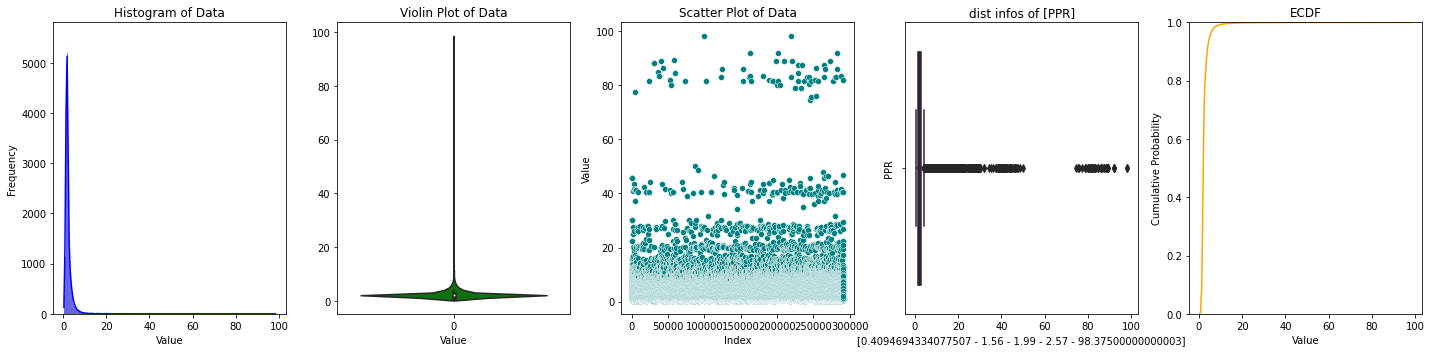


====> CreditRange



KeyError: 'CreditRange'

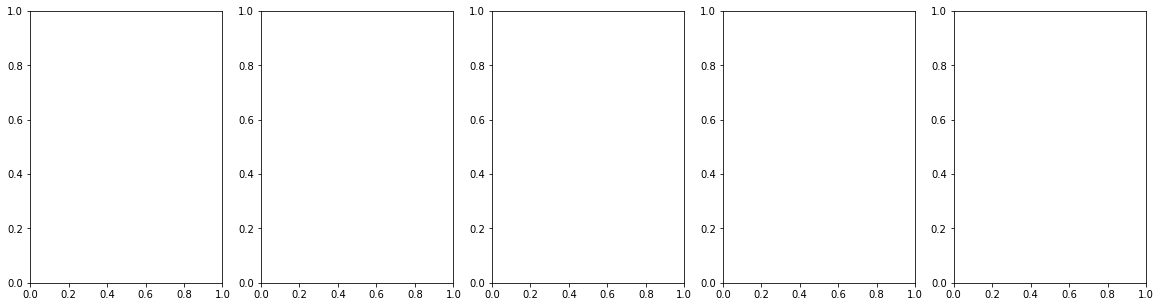

In [32]:
# visualize Univariate analysis
def visualize_univariate_analysis(col):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Create 1 row with 5 columns for the plots
    print(f"\n====> {col}\n")

    # Histogram
    sns.histplot(data[col], kde=True, color='blue', ax=axes[0])
    axes[0].set_title('Histogram of Data')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')

    # Violin Plot
    sns.violinplot(data[col], color='green', ax=axes[1])
    axes[1].set_title('Violin Plot of Data')
    axes[1].set_xlabel('Value')

    # Scatter Plot
    sns.scatterplot(x=np.arange(len(data[col])), y=data[col], color='teal', ax=axes[2])
    axes[2].set_title('Scatter Plot of Data')
    axes[2].set_xlabel('Index')
    axes[2].set_ylabel('Value')


    # Box plot
    sns.boxplot(x=data[col], color='purple', ax=axes[3])
    axes[3].set_title(f'dist infos of [{col}]')
    axes[3].set_ylabel(col)

    quantile = data[col].quantile([0.25,0.5,0.75])
    Q1 = quantile[0.25]
    Q3 = quantile[0.75]
    median = data[col].median()
    min = data[col].min()
    max = data[col].max()
    axes[3].set_xlabel(f"[{min} - {Q1:.3} - {median:.3} - {Q3:.3} - {max}]")


    # Empirical Cumulative Distribution Function (ECDF)
    sns.ecdfplot(data[col], color='orange', ax=axes[4])
    axes[4].set_title('ECDF')
    axes[4].set_xlabel('Value')
    axes[4].set_ylabel('Cumulative Probability')

    plt.tight_layout()
    plt.show()

# Visualize for each numerical column
uni_num_cols = ["PPR" ,"CreditRange", "OrigUPB", "LTV_Range", "OCLTV", "MIP", "OrigInterestRate", "DTI"]
for col in uni_num_cols:
  visualize_univariate_analysis(col)

In [ ]:
discrete_vars = []
continuous_vars = []
# Loop through each column and determine its data type
for column in data.columns:
    if pd.api.types.is_integer_dtype(data[column]) or pd.api.types.is_bool_dtype(data[column]):
        discrete_vars.append(column)
    elif pd.api.types.is_float_dtype(data[column]):
        continuous_vars.append(column)

print("Discrete Variables:", discrete_vars)
print("Continuous Variables:", continuous_vars)

In [33]:

def bivariate_analysis_continuous_data(data, col, tv):
    # Create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))

    # Line plot
    axs[0].plot(data[col], data[tv], marker='o')
    axs[0].set_xlabel(tv)
    axs[0].set_ylabel(col)
    axs[0].set_title('Line Plot')
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].xaxis.set_major_formatter('{:.3f}'.format)

    # Scatter Plot
    axs[1].scatter(data[col], data[tv], marker='o', color='b')
    axs[1].set_xlabel(col)
    axs[1].set_ylabel(tv)
    axs[1].set_title('Scatter Plot')
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].xaxis.set_major_formatter('{:.3f}'.format)

    plt.tight_layout()
    plt.show()

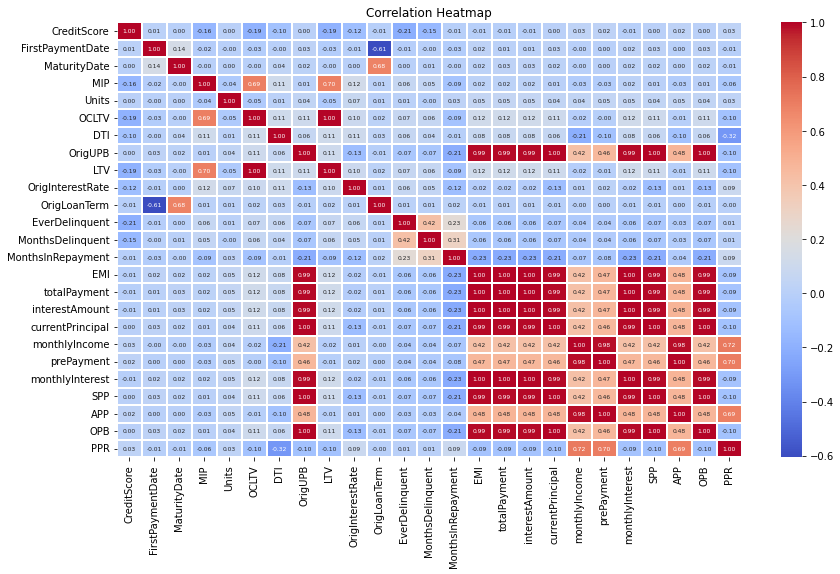

In [34]:
plt.figure(figsize=(14, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2, annot_kws={"size": 6})
plt.title('Correlation Heatmap')
plt.show()

In [35]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_regression

def make_mi_score_and_plot(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    # ploting the scores for each feature

    plt.figure(dpi=100, figsize=(10, 6))
    mi_scores = mi_scores.sort_values(ascending=True)
    width = np.arange(len(mi_scores))
    ticks = list(mi_scores.index)
    plt.barh(width, mi_scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    return mi_scores


X = data.copy()
y = X.pop("PPR")

mi_scores = make_mi_score_and_plot(X, y)

ValueError: could not convert string to float: 'N'

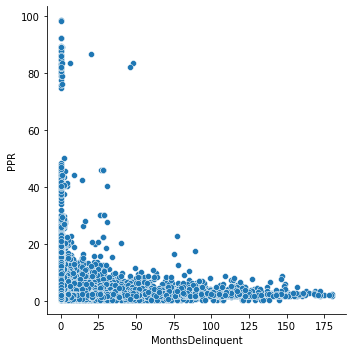

In [36]:
sns.relplot(x="MonthsDelinquent", y="PPR", data=data)

In [37]:
X = data.copy()
y = X.pop('PPR')

In [38]:
from sklearn.decomposition import PCA

# new dimensionality
n_components = 26

# Create principal components
pca = PCA(n_components=n_components) # n_components = n_features by default
X_pca = pca.fit_transform(X)

# Convert to dataframe
pca_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=pca_names)

X_pca_mi_score = make_mi_score_and_plot(X_pca, y)

ValueError: could not convert string to float: 'N'

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pca_names,
    index=X.columns,
)
loadings

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_mi_score, y, test_size=0.3, random_state=40)

In [ ]:
DT_model = DecisionTreeRegressor(criterion='squared_error')
DT_model.fit(X_train, y_train)
DT_pred = DT_model.predict(X_test)

DT_MSE = mean_squared_error(y_test, DT_pred)
DT_R2 = r2_score(y_test, DT_pred)

In [ ]:
print(f"MSE ------>: {DT_MSE} /nR2 score ------->: {DT_R2}")

In [ ]:
XGB_model = XGBRegressor( max_depth=7, n_estimators=300, random_state=40 )
XGB_model.fit(X_train, y_train)
XGB_pred = XGB_model.predict(X_test)

XGB_MSE = mean_squared_error(y_test, XGB_pred)
XGB_R2 = r2_score(y_test, XGB_pred)

In [ ]:
print(f"MSE ------>: {XGB_MSE} /nR2 score ------->: {XGB_R2}")